# ArchPy2Modflow: Energy Transport with Modflow 6

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import pyvista as pv
import sys
import os

# auto reload modules
%load_ext autoreload
%autoreload 2


sys.path.append("../../")
#my modules
from ArchPy.base import *
from ArchPy.tpgs import *

In [2]:
#grid
sx = 1.5
sy = 1.5
sz = .15
x0 = 0
y0 = 0
z0 = -15
nx = 100
ny = 50
nz = 50
x1 = x0 + nx*sx
y1 = y0 + ny*sy
z1 = z0 + nz*sz

dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (x0, y0, z0)  

In [3]:
## create pile

P1 = Pile(name = "P1",seed=1)

#units covmodel
covmodelD = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodelD1 = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[30,30]})])
covmodelC = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[40,40]})])
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodel_er = gcm.CovModel2D(elem=[('spherical', {'w':1, 'r':[50,50]})])

# facies covmodels
covmodel_f_B = gcm.CovModel3D(elem=[('spherical', {'w':.25, 'r':[20, 20, 2]})])

#create Lithologies 
dic_s_D = {"int_method" : "grf_ineq","covmodel" : covmodelD}
dic_f_D = {"f_method":"homogenous"}
D = Unit(name="D",order=1,ID = 1,color="gold",contact="onlap",surface=Surface(contact="onlap",dic_surf=dic_s_D)
         ,dic_facies=dic_f_D)

dic_s_C = {"int_method" : "grf_ineq","covmodel" : covmodelC, "mean":-8.5}
dic_f_C = {"f_method":"homogenous"}
C = Unit(name="C", order=2, ID = 2, color="blue", contact="onlap", dic_facies=dic_f_C, surface=Surface(dic_surf=dic_s_C, contact="onlap"))

dic_s_B = {"int_method" : "grf_ineq","covmodel" : covmodelB, "mean":-9.5}
dic_f_B = {"f_method":"SIS", "f_covmodel":[covmodel_f_B], "probability":[0.3, 0.6, 0.1]}
B = Unit(name="B",order=3,ID = 3,color="purple",contact="onlap",dic_facies=dic_f_B,surface=Surface(contact="onlap",dic_surf=dic_s_B))

dic_s_A = {"int_method":"grf_ineq","covmodel": covmodelB, "mean":-13}
dic_f_A = {"f_method":"homogenous"}
A = Unit(name="A",order=4, ID = 4,color="red",contact="onlap",dic_facies=dic_f_A,surface=Surface(dic_surf = dic_s_A,contact="onlap"))

#Master pile
P1.add_unit([D,C,B,A])

Unit D: Surface added for interpolation
Unit C: Surface added for interpolation
Unit B: Surface added for interpolation
Unit A: Surface added for interpolation
Stratigraphic unit D added
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added


In [4]:
# covmodels for the property model
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.3,"r":[30,30,10]})],alpha=-20,name="K_vario")
covmodelK2 = gcm.CovModel3D(elem=[("spherical",{"w":0.1,"r":[20,20, 5]})],alpha=0,name="K_vario_2")

facies_1 = Facies(ID = 1,name="Sand",color="yellow")
facies_2 = Facies(ID = 2,name="Gravel",color="lightgreen")
facies_4 = Facies(ID = 4,name="Clay",color="blue")
facies_7 = Facies(ID = 7,name="basement",color="red")

A.add_facies([facies_7])
B.add_facies([facies_1, facies_2, facies_4])
D.add_facies([facies_1])
C.add_facies([facies_4])

# property model
cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.5, "r":[10, 10, 10]}),
                                  ("cubic", {"w":0.5, "r":[15, 15, 15]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.5, "r":[25, 25, 5]})])

list_facies = [facies_1, facies_2, facies_4, facies_7]
means = [-4, -2, -8, -10]
prop_model = ArchPy.base.Prop("K",
                              facies = list_facies,
                              covmodels = None,
                                means = means,
                                int_method = "homogenous",
                                vmin = -10,
                                vmax = -1
                                )

Facies basement added to unit A
Facies Sand added to unit B
Facies Gravel added to unit B
Facies Clay added to unit B
Facies Sand added to unit D
Facies Clay added to unit C


In [5]:
top = np.ones([ny,nx])*z1
bot = np.ones([ny,nx])*z0

In [6]:
T1 = Arch_table(name = "P1",seed=3)
T1.set_Pile_master(P1)
T1.add_grid(dimensions, spacing, origin, top=top,bot=bot)
T1.add_prop(prop_model)


Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##
Property K added


In [7]:
T1.compute_surf(1)
T1.compute_facies(1)
T1.compute_prop(1)

Boreholes not processed, fully unconditional simulations will be tempted
########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.021019458770751953 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.015013933181762695 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.01601409912109375 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.02602410316467285 s
##########################


### 0.08307504653930664: Total time elapsed for computing surfaces ###

### Unit D: facies simulation with homogenous method ####
### Unit D - realization 0 ###
Time elapsed 0.0 s

### Unit C: facies simulation with homogenous method ####
### Unit C - realization 0 ###
Time elapsed 0.0 s

### Unit B: facies simulation with SIS method ####
### Unit B - realization 0 ##

In [8]:
pv.set_jupyter_backend("static")

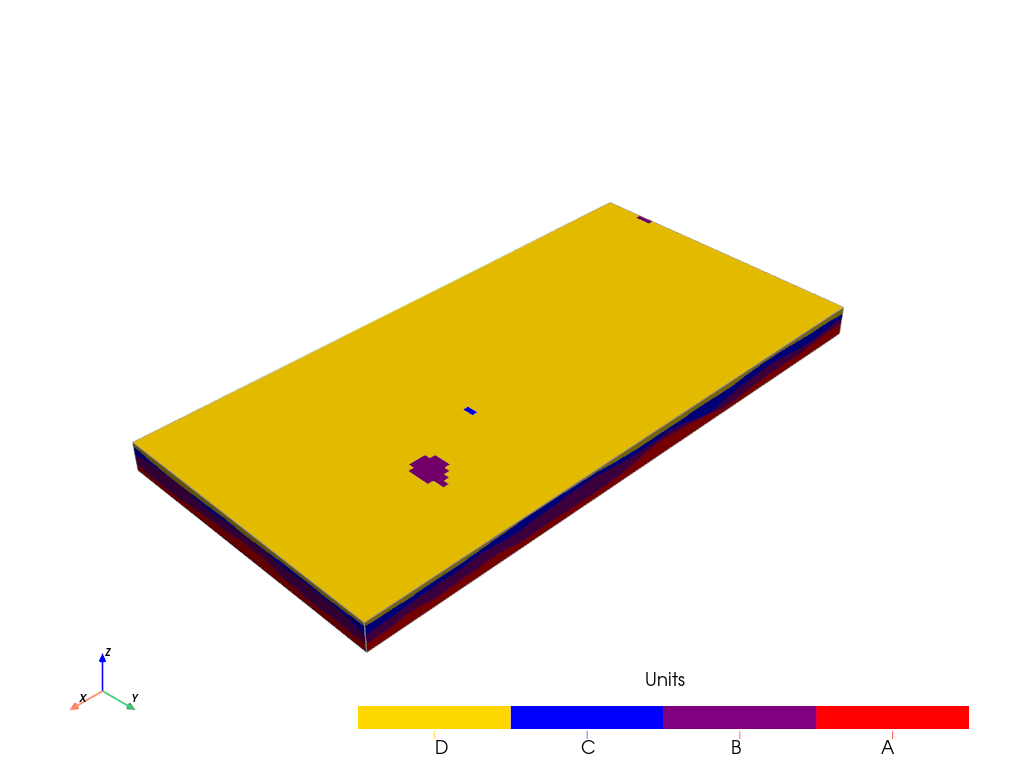

In [9]:
T1.plot_units()

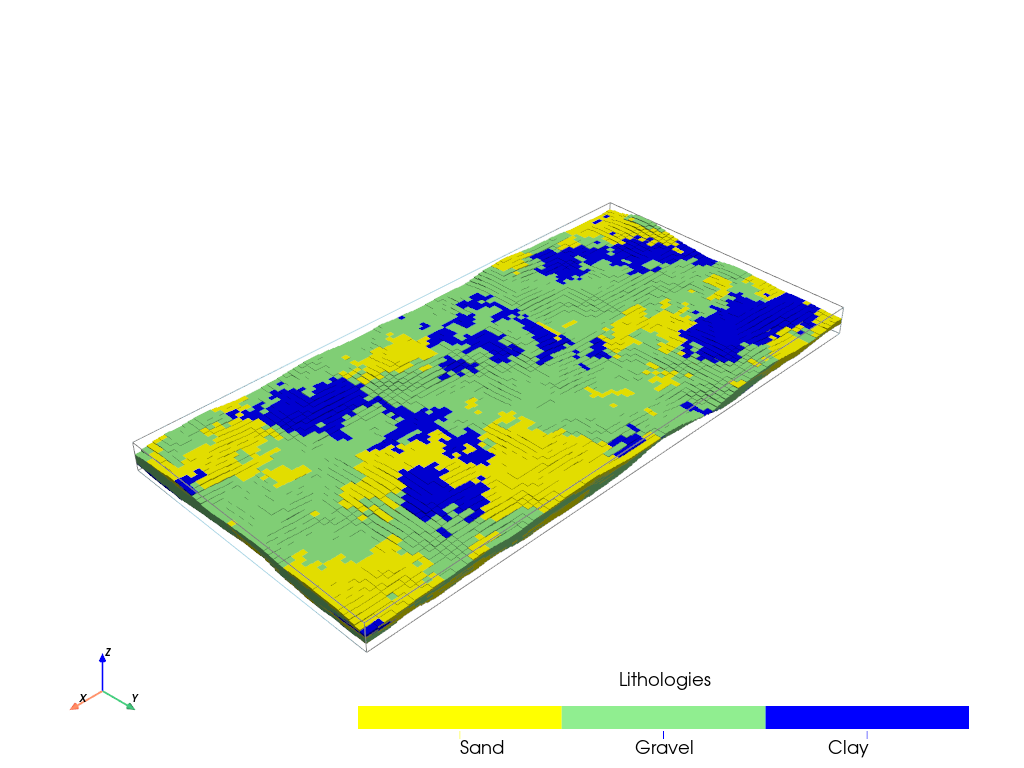

In [10]:
T1.plot_facies(inside_units=[B])

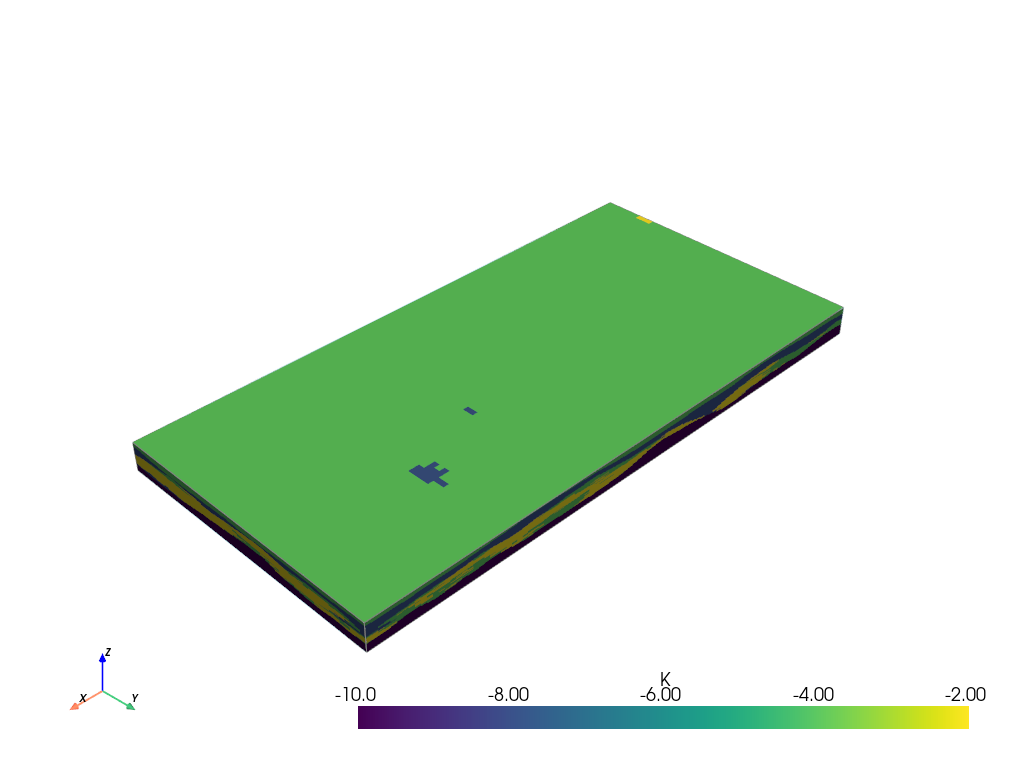

In [11]:
T1.plot_prop("K")

### Flow model

In [12]:
import ArchPy.ap_mf
from ArchPy.ap_mf import archpy2modflow, array2cellids

In [13]:
mf6_exe_path = "../../../../exe/mf6.exe"

In [153]:
archpy_flow = archpy2modflow(T1, exe_name=mf6_exe_path)  # create the modflow model
archpy_flow.create_sim(grid_mode="layers", iu=0, unit_limit=None, lay_sep=[1, 1, 3, 1])  # create the simulation object and choose a certain discretization
archpy_flow.set_k("K", iu=0, ifa=0, ip=0, log=True, k_average_method="anisotropic")  # set the hydraulic conductivity

Simulation created
To retrieve the simulation, use the get_sim() method


In [154]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [155]:
import flopy as fp

In [156]:
sim.ims.remove()
inner_dvclose = 1e-5
ims = fp.mf6.ModflowIms(sim, complexity="moderate", inner_dvclose=inner_dvclose)

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\pyvista\plotting\_property.py:250: UserWarning: `edge_opacity` cannot be used under VTK v9.3.0. Try installing VTK v9.3.0 or newer.
  warnings.warn(


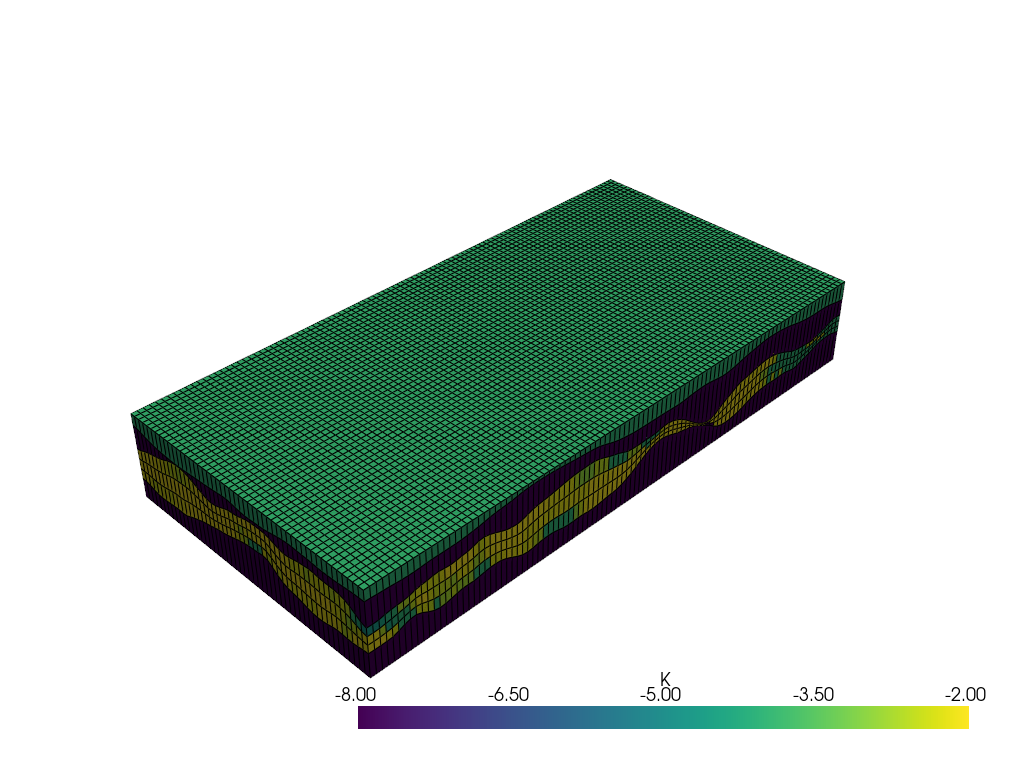

In [157]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

vtk.add_array(np.log10(gwf.npf.k.array), name="K")
vtk.add_array(gwf.dis.idomain.array, name="IDOMAIN")
gwf_mesh = vtk.to_pyvista()

ghosts = np.argwhere(gwf_mesh["K"] > 1)
gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="K", cmap="viridis", clim=[-8, -2], edge_opacity=0.3)
pl.show()

In [158]:
import flopy as fp

In [159]:
# add BC at left and right on all layers
h1 = .3
h2 = 0
T_1 = 10  # temperature at left boundary
T_2 = 10  # temperature at right boundary
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1, T_1))

chd1 = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True, auxiliary="TEMPERATURE", pname="CHD-1")

chd_data = []
a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2, T_2))

chd2 = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True, auxiliary="TEMPERATURE", pname="CHD-2")

In [165]:
# add an injection well in the middle of the model
well_data = []
Q_well = 0.001  # m3/s
T_well = 7  # temperature of the injected water
cellid_well = (2, T1.ny // 2, T1.nx // 2)
well_data.append((cellid_well, Q_well, T_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, auxiliary="TEMPERATURE", pname="WEL-INJ")

# production well
well_data = []
Q_well = -0.001  # m3/s
cellid_well = (2, T1.ny // 2, T1.nx // 3)
well_data.append((cellid_well, Q_well))
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=well_data, save_flows=True, pname="WEL-PROD")

In [166]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd-1...
    writing package chd-2...
    writing package wel-inj...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package wel-prod...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 14 2025 13:40:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R

(True, [])

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\pyvista\plotting\_property.py:250: UserWarning: `edge_opacity` cannot be used under VTK v9.3.0. Try installing VTK v9.3.0 or newer.
  warnings.warn(


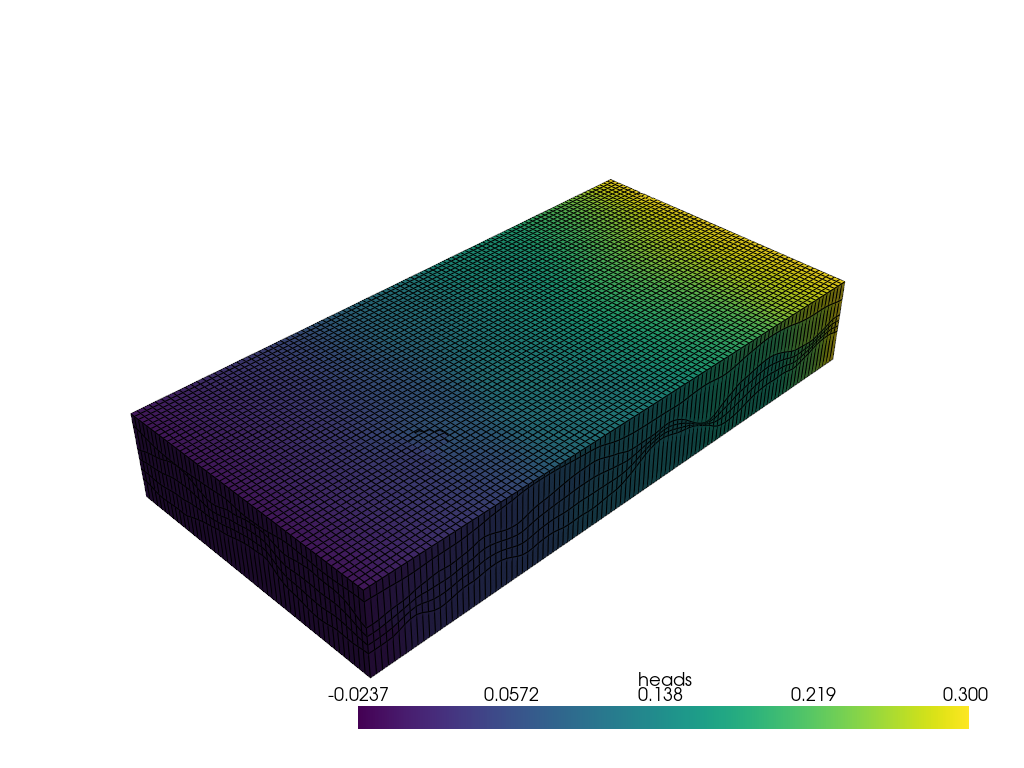

In [167]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

heads = archpy_flow.get_heads()
vtk.add_array(heads, name="heads")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")

gwf_mesh = vtk.to_pyvista()
ghosts = np.argwhere(gwf_mesh["idomain"] <= 0)
gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="heads", cmap="viridis", edge_opacity=0.3)
pl.show()


In [169]:
T1.ny

50

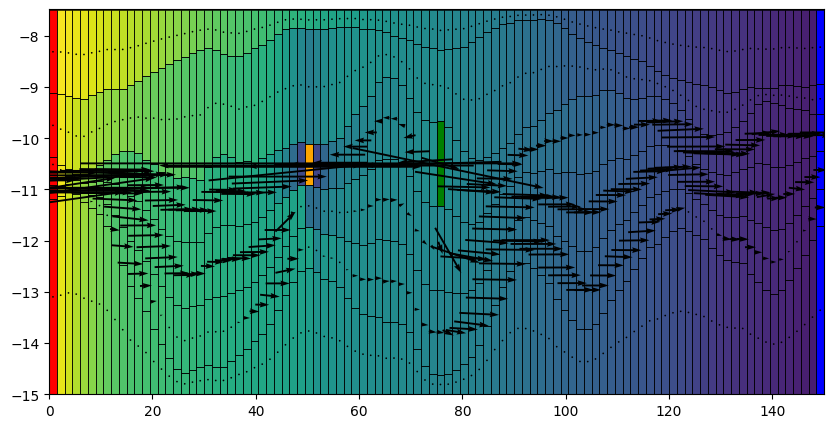

In [170]:
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

# plot cross section
from flopy.plot import PlotCrossSection
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cross_section = PlotCrossSection(model=gwf, line={"row": 25})
# cross_section.plot_array(np.log10(gwf.npf.k.array), cmap="Blues", ax=ax)
cross_section.plot_array(heads, cmap="viridis", ax=ax)
cross_section.plot_bc("CHD-1", color="red", ax=ax)
cross_section.plot_bc("CHD-2", color="blue", ax=ax)
cross_section.plot_bc("WEL-INJ", color="green", ax=ax)
cross_section.plot_bc("WEL-PROD", color="orange", ax=ax)
cross_section.plot_vector(qx, qy, qz, color="black", normalize=False)
cross_section.plot_grid(linewidth=0.5, color="black")

### Heat model

In [171]:
sim_name = sim.name
workspace = archpy_flow.model_dir

In [172]:
# parameters
strt_temp = 10
scheme = "TVD"  # Advection solution scheme
ktw = 0.56  # Thermal conductivity of water W/m·K
kts = 2.50  # Thermal conductivity of aquifer material W/m·K
al = 10  # dispersivity in longitudinal direction ($m^2/s$)
ath1 = 1  # transverse dispersivity ($m^2/s$)
prsity = 0.2  # porosity
cpw = 4186  # specific heat capacity of water J/kg·K
cps = 840  # specific heat capacity of solid J/kg·K
rhow = 1000  # density of water kg/m3
rhos = 2650  # density of solid kg/m3
lhv = 2.26e6  # latent heat of vaporization J/kg

In [173]:
# al = [0, 0, 0, 2, 2, 0]
# ath1 = [0, 0, 0, .5, .5, 0]

In [215]:
gwename = "gwe-" + sim_name
sim_ws = os.path.join(workspace, gwename)
sim_e = fp.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name=mf6_exe_path)

# Instantiating MODFLOW 6 groundwater transport model
gwe = fp.mf6.MFModel(
    sim_e,
    model_type="gwe6",
    modelname=gwename,
    model_nam_file=f"{gwename}.nam",
)

# IMS
imsgwe = fp.mf6.ModflowIms(
    sim_e,
    print_option="SUMMARY",
    complexity="moderate",
)
sim_e.register_ims_package(imsgwe, [gwe.name])

# TDIS
perioddata = [(86400*10e2, 100, 1.0)]
tdis = fp.mf6.ModflowTdis(sim_e, time_units='SECONDS', perioddata=perioddata)


# DIS 
dis = archpy_flow.get_gwf().dis
dis_prt = fp.mf6.ModflowGwfdis(gwe, nlay=dis.nlay.array, nrow=dis.nrow.array, ncol=dis.ncol.array,
                                delr=dis.delr.array, delc=dis.delc.array, top=dis.top.array, botm=dis.botm.array,
                                idomain=dis.idomain.array)

# Instantiating MODFLOW 6 heat transport initial temperature
eic = fp.mf6.ModflowGweic(gwe, strt=strt_temp, filename=f"{gwename}.ic")

# Instantiating MODFLOW 6 heat transport advection package
eadv = fp.mf6.ModflowGweadv(gwe, scheme=scheme, filename=f"{gwename}.adv")

# conduction and dispersion
if ktw != 0:
    cnd = fp.mf6.ModflowGwecnd(
        gwe,
        alh=al,
        ath1=ath1,
        ktw=ktw,
        kts=kts,
        pname="CND",
        filename=f"{gwename}.dsp",
    )

# Instantiating MODFLOW 6 heat transport mass storage package (consider renaming to est)
est = fp.mf6.ModflowGweest(
    gwe,
    porosity=prsity,
    heat_capacity_water=cpw,
    density_water=rhow,
    latent_heat_vaporization=lhv,
    heat_capacity_solid=cps,
    density_solid=rhos,
    pname="EST",
    filename=f"{gwename}.est",
    save_flows=True,
)

# constant temperature packge (CTP)
# ctpspd = {}
# T = 7
# cellid = (2, T1.ny//2, T1.nx//2)
# # ctpspd[0] = [((i, T1.ny//2, T1.nx//2), T) for i in range(0, 10)]
# ctpspd[0] = [(cellid, T)]
# ctp = fp.mf6.ModflowGwectp(
#     gwe,
#     maxbound=len(ctpspd),
#     stress_period_data=ctpspd,
#     save_flows=False,
#     pname="CTP-1",
#     filename=f"{gwename}.ctp",
# )

# Instantiating MODFLOW 6 source/sink mixing (SSM) package for dealing with
# auxiliary temperature specified in constant head and well packages
sourcerecarray = [
    ("CHD-1", "AUX", "TEMPERATURE"),
    ("CHD-2", "AUX", "TEMPERATURE"),
    ("WEL-INJ", "AUX", "TEMPERATURE"),
]
ssm = fp.mf6.ModflowGwessm(gwe, sources=sourcerecarray, filename=f"{gwename}.ssm", save_flows=True)

# Instantiating MODFLOW 6 heat transport output control package
oc = fp.mf6.ModflowGweoc(
    gwe,
    budget_filerecord=f"{gwename}.cbc",
    temperature_filerecord=f"{gwename}.ucn",
    saverecord=[("TEMPERATURE", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("BUDGET", "LAST")],
)

# Instantiating MODFLOW 6 Flow-Model Interface package
pd = [
    ("GWFHEAD", f"../{gwf.name}.hds", None),
    ("GWFBUDGET", f"../{gwf.name}.cbc", None),
]
fmi = fp.mf6.ModflowGwefmi(gwe, packagedata=pd)


In [216]:
sim_e.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model gwe-sim_test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package cnd...
    writing package est...
    writing package ssm...
    writing package oc...
    writing package fmi...


In [217]:
sim_e.run_simulation()

FloPy is using the following executable to run the model: ..\..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 14 2025 13:40:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Gove

(True, [])

In [220]:
pv.set_jupyter_backend("static")

In [221]:
# T1.plot_arr(gwe.output.temperature().get_alldata()[0], cmin=9, cmax=10, cmap="jet")

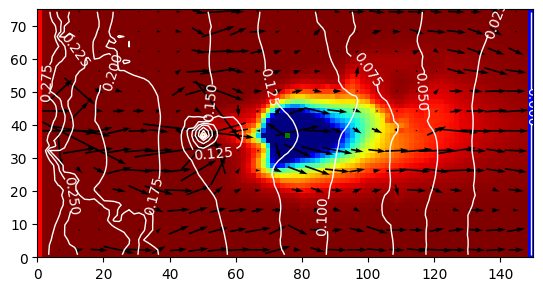

In [222]:
i = 0

ml = fp.plot.PlotMapView(model=gwf, layer=2)
ml.plot_array(gwe.output.temperature().get_alldata()[i], cmap="jet", vmin=9, vmax=10)

cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)
cont = ml.contour_array(gwf.output.head().get_alldata()[i], levels=15, colors="white", linewidths=1)
# display head values on contour lines
plt.clabel(cont, fmt="%.3f")


ml.plot_vector(qx, qy, normalize=False, istep=4, jstep=4 )
ml.plot_bc("CHD-1", color="red")
ml.plot_bc("CHD-2", color="blue")
ml.plot_bc("WEL-INJ", color="green")
ml.plot_bc("WEL-PROD", color="orange")

Check heat connexion and see if heat front is not reaching the production well.

Text(0, 0.5, 'Temperature (°C)')

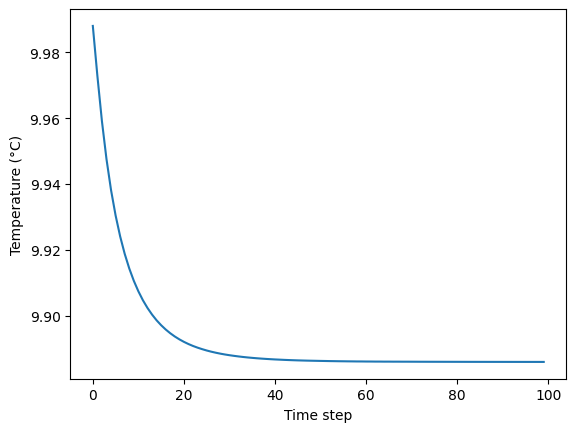

In [223]:
plt.plot(gwe.output.temperature().get_alldata()[:, *gwf.wel[1].stress_period_data.array[0].cellid[0]])
plt.xlabel("Time step")
plt.ylabel("Temperature (°C)")

Temperature of production well is only decreasing by 0.1°C which is reasonable. --> no major impact of the heat front on the production well.

### 3D plots

Plot at the first iteration (1 days)

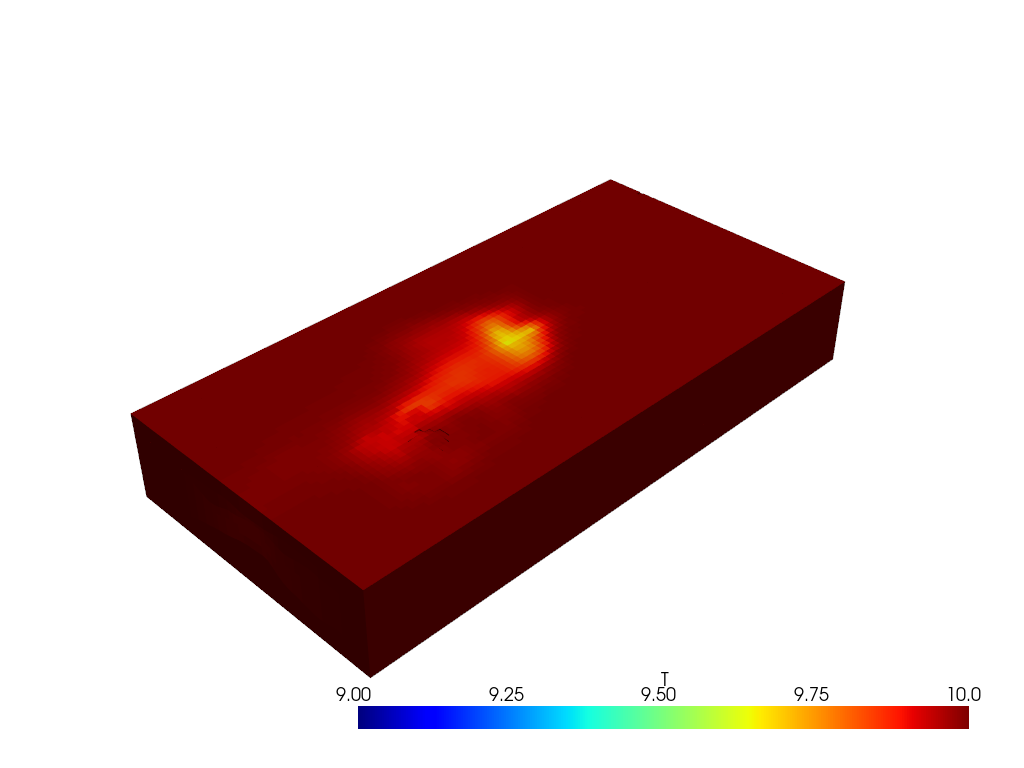

In [225]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

heads = archpy_flow.get_heads()
vtk.add_array(gwe.output.temperature().get_alldata()[0], name="T")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")

gwf_mesh = vtk.to_pyvista()
ghosts = np.argwhere(gwf_mesh["idomain"] <= 0)
gwf_mesh.remove_cells(ghosts, inplace=True)
# ghosts = np.argwhere(gwf_mesh["T"] >= 9.9)
# gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=False, scalars="T", cmap="jet", clim=[9, 10])
pl.show()

Plot at the end of the simulation (100 days)

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\pyvista\plotting\_property.py:250: UserWarning: `edge_opacity` cannot be used under VTK v9.3.0. Try installing VTK v9.3.0 or newer.
  warnings.warn(


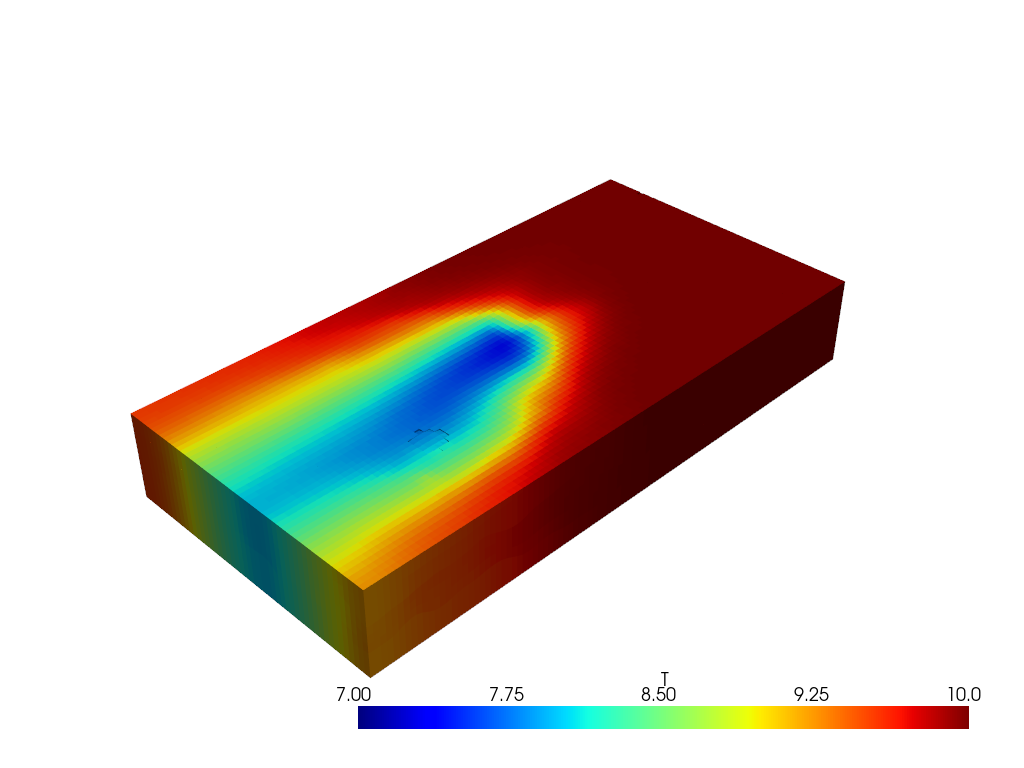

In [227]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

heads = archpy_flow.get_heads()
vtk.add_array(gwe.output.temperature().get_alldata()[-1], name="T")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")

gwf_mesh = vtk.to_pyvista()
ghosts = np.argwhere(gwf_mesh["idomain"] <= 0)
gwf_mesh.remove_cells(ghosts, inplace=True)
# ghosts = np.argwhere(gwf_mesh["T"] >= 9.9)
# gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=False, scalars="T", cmap="jet", clim=[7, 10], edge_opacity=0.3)
pl.show()

Other fancy plots such as heat exchange between water and rock

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\pyvista\plotting\_property.py:250: UserWarning: `edge_opacity` cannot be used under VTK v9.3.0. Try installing VTK v9.3.0 or newer.
  warnings.warn(


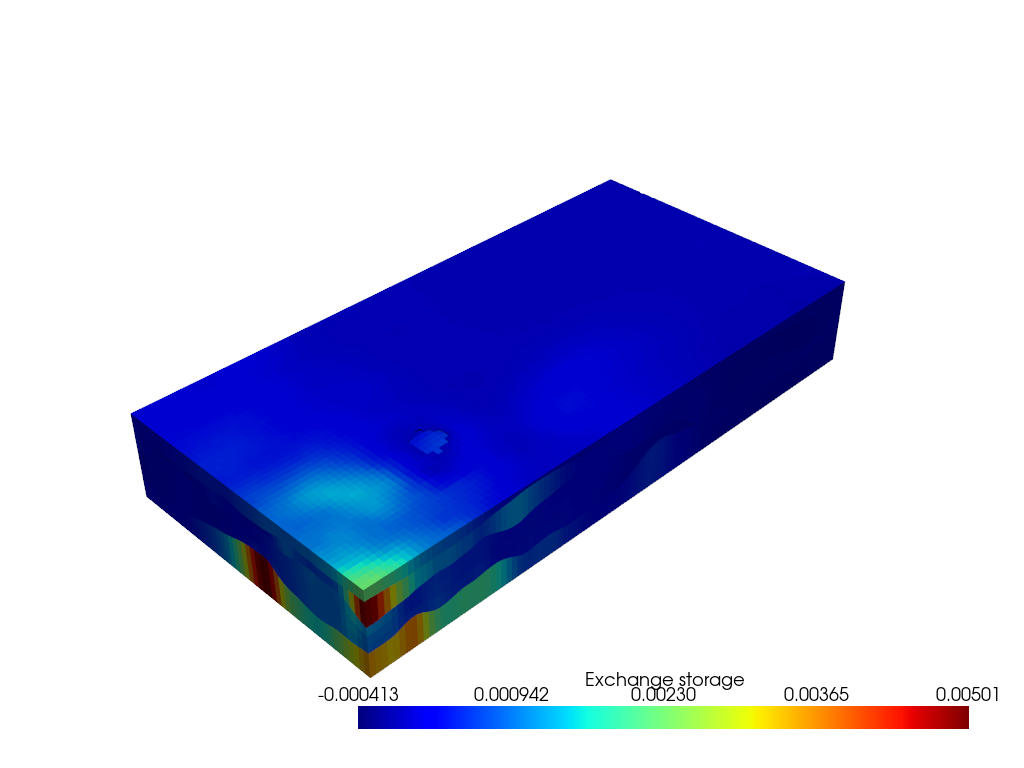

In [219]:
budget_e = gwe.output.budget()

from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

heads = archpy_flow.get_heads()
vtk.add_array(budget_e.get_data(text="STORAGE-CELLBLK", kstpkper=(99, 0))[0], name="Exchange storage")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")

gwf_mesh = vtk.to_pyvista()
ghosts = np.argwhere(gwf_mesh["idomain"] <= 0)
gwf_mesh.remove_cells(ghosts, inplace=True)
# ghosts = np.argwhere(gwf_mesh["T"] >= 9.9)
# gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=False, scalars="Exchange storage", cmap="jet", edge_opacity=0.3)
pl.show()